In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [4]:
#Importing the other necessary libraries
import os
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
#Importing OpenCV - the computer vision library
import cv2

In [6]:
# Glob the training data and load a single image path
training_paths = pathlib.Path('./stage1_train').glob('*/images/*.png')
training_sorted = sorted([x for x in training_paths])
im_path = training_sorted[45]

Original Image Shape (520, 696, 3)


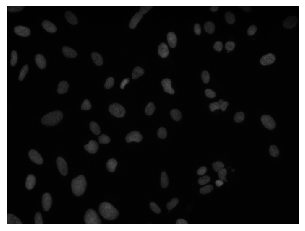

In [7]:
#To read the image 
bgrimg = cv2.imread(str(im_path))
plt.imshow(bgrimg)
plt.xticks([]) # To get rid of the x-ticks and y-ticks on the image axis 
plt.yticks([])
print('Original Image Shape',bgrimg.shape)

In [8]:
#To see the structure of the image let's display one row of the image matrix
print('The first row of the image matrix contains',len(bgrimg[1]),'pixels')
print(bgrimg[1])

The first row of the image matrix contains 696 pixels
[[ 3  3  3]
 [ 6  6  6]
 [13 13 13]
 ..., 
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1  1]]


The image has been read in the BGR colorspace. We have a third dimension as every pixel is represented by it's B, G and R components. This is the default colorpsace in which images are read in OpenCV. A particular BGR/RGB color space is defined by the three chromaticities of the red, green, and blue additive primaries, and can produce any chromaticity that is the triangle defined by those primary colors. In simpler terms - An RGB color can be understood by thinking of it as all possible colors that can be made from three colored lights for red, green, and blue. For more information : https://en.wikipedia.org/wiki/RGB_color_space

In [9]:
bgrimg[1].shape

(696, 3)

# Basic Solution

In [10]:
# To transfrom the colorspace from BGR to grayscale so as to make things simpler
grayimg = cv2.cvtColor(bgrimg,cv2.COLOR_BGR2GRAY)


New Image Shape (520, 696)


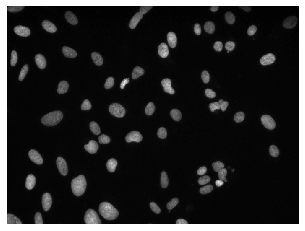

In [11]:
#To plot the image
plt.imshow(grayimg,cmap='gray') #cmap has been used as matplotlib uses some default colormap to plot grayscale images
plt.xticks([])
plt.yticks([])
print('New Image Shape',grayimg.shape)

It is important to understand the structure of the image here. We reduced a dimension when we transformed from the BGR colorspace to grayscale. Why did this happen? This is because grayscale is a range of monochromatic shades from black to white. Therefore, a grayscale image contains only shades of gray and no color (i.e it primarily contains only black and white). Transforming the colorspace removes all color information, leaving only the luminance of each pixel. Since digital images are displayed using a combination of red, green, and blue (RGB) colors, each pixel has three separate **luminance** values. Therefore, these three values must be combined into a single value when removing color from an image. Luminance can also be described as **brightness** or **intensity**, which can be measured on a scale from black (zero intensity) to white (full intensity)

In [12]:
#To understand this further, let's display one entire row of the image matrix
print('The first row of the image matrix contains',len(grayimg[1]),'pixels')
print(grayimg[1])

The first row of the image matrix contains 696 pixels
[ 3  6 13 19 20 22 26 27 27 25 24 25 25 26 30 30 31 32 29 28 27 31 32 31 30
 30 32 32 31 28 30 31 33 29 27 25 25 24 22 22 20 16 10  6  4  2  2  2  2  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  2
  2  1  2  2  2  1  1  2  2  2  2  1  1  1  1  2  1  1  1  1  1  1  1  2  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  2  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  2  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2
  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  2  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  2  1  1  1  1 

**Removing the background**

/Users/StevenTseng/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Distribution of intensity values (Zoomed In)')

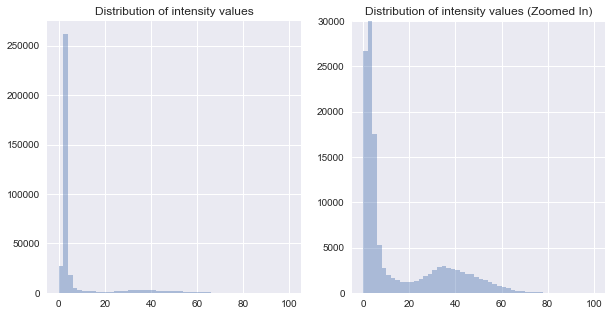

In [13]:
# let's look at the distribution of the intensity values of all the pixels
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(grayimg.flatten(),kde=False)#This is to flatten the matrix and put the intensity values of all the pixels in one single row vector
plt.title('Distribution of intensity values')

#To zoom in on the distribution and see if there is more than one prominent peak 
plt.subplot(1,2,2)
sns.distplot(grayimg.flatten(),kde=False) 
plt.ylim(0,30000) 
plt.title('Distribution of intensity values (Zoomed In)')

We can see that there are 2 prominent peaks. The count of pixels with intensity values around 0 is extrememly high (250000). We would expect this to occur as the nuclei cover a smaller portion of the picture as compared to the background which is primarily black. Our job here is to seperate the two, that is, seperate the nuclei from the background. The optimal seperation value is somewhere around 20 but rather than relying on such descriptive statistics, we should take a more formal approach such as using Otsu's method. Otsu's method, named after Nobuyuki Otsu is used to automatically perform clustering-based image thresholding, or, the reduction of a graylevel image to a binary image. The algorithm assumes that the image contains two classes of pixels following bi-modal histogram (foreground pixels and background pixels), it then calculates the optimum threshold separating the two classes so that their combined spread (intra-class variance) is minimal, or equivalently, so that their inter-class variance is maximal. Otsu’s method exhibits relatively good performance if the histogram can be assumed to have bimodal distribution and assumed to possess a deep and sharp valley between two peaks 

source : https://en.wikipedia.org/wiki/Otsu%27s_method



In [14]:
from skimage.filters import threshold_otsu
thresh_val = threshold_otsu(grayimg)
print('The optimal seperation value is',thresh_val)

The optimal seperation value is 21


In [15]:
mask=np.where(grayimg>thresh_val,1,0)

([], <a list of 0 Text yticklabel objects>)

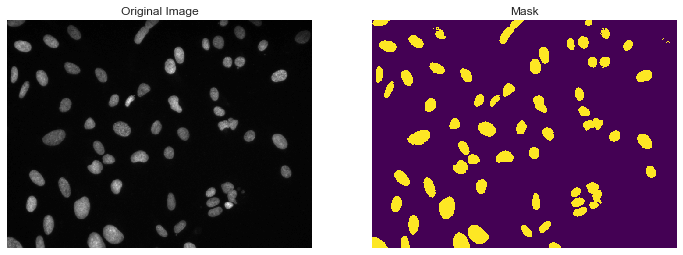

In [16]:
#To plot the original image and mask side by side
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(grayimg,cmap='gray')
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
maskimg = mask.copy()
plt.imshow(maskimg, cmap='viridis')
plt.title('Mask')
plt.xticks([])
plt.yticks([])

We see that the mask has done a decent job. If these images were to appear in a newspaper column titled 'Spot the difference between' (except the obvious colour difference), it would have had people scratch their heads in frustration. However a more careful look suggests that the mask hasn't found out all the nuclei, especially the two in the top right corner. Around the (500,400) mark, the three nuclei have been all combined together to form one cluster. The darker coloured nuclei are causing a problem as the pixels that represent these nuclei have intensity values lesser than Otsu's threshold value.



Text(0.5, 1.0, 'Mask with Otsu Seperation')

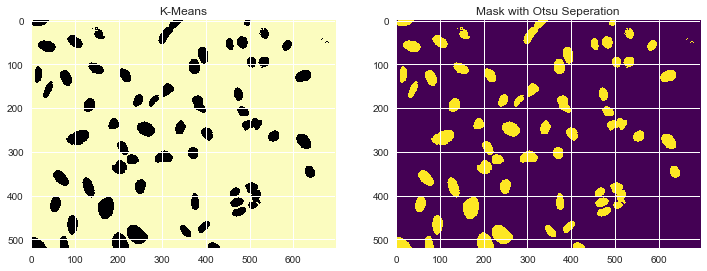

In [17]:
#Let's see if K-Means does a good job on this data 
from sklearn.cluster import KMeans
kmeans=KMeans(n_clusters=2) #2 as we're still trying to seperate the lighter coloured nuclei from the darker coloured background 
kmeans.fit(grayimg.reshape(grayimg.shape[0]*grayimg.shape[1],1))

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(kmeans.labels_.reshape(520,696),cmap='magma')
plt.title('K-Means')

plt.subplot(1,2,2)
plt.imshow(maskimg, cmap='viridis')
plt.title('Mask with Otsu Seperation')

It's extrememly hard to tell if there's a difference. Let's see if there is any difference by comparing the labels of Otsu and K-Means at a pixel level, summing over the booleans and dividing them by the total number of pixels in the image. If the result is 1, it means there is no difference at all

In [18]:
#To check if there's any difference
sum((kmeans.labels_.reshape(520,696)==mask).flatten())/(mask.shape[0]*mask.shape[1])

0.0

**Object identification**

To get a count of the total number of nuclei, we can use the ndimage.label function which labels features (pixels) in an array based on their interconnectedness. So for example if [1 1 1 0 0 1 1] was our row vector, using ndimage.label on this would give us [1 1 1 0 0 2 2] signifying the fact that there are 2 distinct objects in the row vector. The function returns the labeled array and the number of distinct objects it found in the array.

For more information on connected components : http://aishack.in/tutorials/pixel-neighbourhoods-connectedness/

In [19]:
from scipy import ndimage

In [20]:
# ndimage example
#To see this at a matrix level
matrix = np.array([[0,0,1,1,1,1],
                  [0,0,0,0,1,1],
                  [1,1,0,1,1,1],
                  [1,1,0,1,1,1]])
matrix


array([[0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1],
       [1, 1, 0, 1, 1, 1],
       [1, 1, 0, 1, 1, 1]])

In [21]:

#Applying the ndimage.label function
ndimage.label(matrix)

(array([[0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1],
        [2, 2, 0, 1, 1, 1],
        [2, 2, 0, 1, 1, 1]], dtype=int32), 2)

In [22]:
labels,nlabels=ndimage.label(mask)
print('There are',nlabels,'distinct nuclei in the mask.')

There are 70 distinct nuclei in the mask.


Now, there could be more nuclei than that as some nuclei have been combined into one and our mask hasn't been able to identify all the nuclei, especially the ones in the top right corner. However the 2 seperate spots in the top right corner get labelled as 2 different objects.

All in all the two major problems in this image are:

Insignificant spots/dots being labelled as nuclei. These spots should have their labels (KMeans, Otsu) set to 0 if their sizes are too small. This problem has been caused by some nuclei that have pixels where the intensity values are lesser than Otsu's threshold value, thus causing only some pixels to have their label encoded as 1.
The nuclei that are closer to one another get clustered to form one nuclei. So we need to seperate them using some edge detection algorithm (like convolution with a **sobel filter** or **canny edge detector** as suggested by Ramsu)
Now for this competition we need to have a seperate mask for every nucleus. In the file named 'stage1_train_labels.csv.zip', we have the image IDs in one column and the Run Length Encoded (RLE) vector for one such mask (i.e for one nucleus) in the other column.



In [23]:
#Since we need to create a seperate mask for every nucelus, let's store the masks in an iterable like a list 
label_array=[]
#We need to iterate from 1 as ndimage.label encodes every object starting from number 1
for i in range(1,nlabels+1):
    label_mask = np.where(labels==i,1,0)
    label_array.append(label_mask)
#To see one such mask
label_array[68]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

**Run Length Encoding**

Every mask for every nucleus requires an RLE vector. This is the format required by the competition.

What is **RLE**?

RLE or Run Length Encoding converts a matrix into a vector and returns the position/starting point of the first pixel from where we observe an object (identified by a 1) and gives us a count of how many pixels from that pixel we see the series of 1s. In the ndimage.label function example of [1 1 1 0 0 1 1], running RLE would give us 1 3 6 2, which means 3 pixels from the zeroth pixel (inclusive) and 2 pixels from the 5th pixel we see a series of 1s



In [24]:
#Function for rle encoding
def rle(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

In [25]:
#Running RLE on the last label_mask in label_array gives us 
rle(label_mask)

'210075 6 210593 8 211112 9 211631 10 212150 11 212669 12 213189 12 213709 12 214228 13 214748 13 215268 13 215788 13 216308 13 216828 13 217348 13 217869 12 218389 12 218909 12 219430 11 219950 11 220471 10 220991 10 221512 9 222033 8 222554 7 223075 6 223596 5 224117 4 224640 1'

#### Putting everything together

In [26]:
#To take a look at the different parts
im_path.parts

('/',
 'Users',
 'StevenTseng',
 'Desktop',
 'stage1_train',
 '10ba6cbee4873b32d5626a118a339832ba2b15d8643f66dddcd7cb2ec80fbc28',
 'images',
 '10ba6cbee4873b32d5626a118a339832ba2b15d8643f66dddcd7cb2ec80fbc28.png')

In [27]:
def basic(im_path):
    #Reading the image
    im_id=im_path.parts[-3] #To extract the image ID
    bgr = cv2.imread(str(im_path)) #Reading it in OpenCV
    gray = cv2.cvtColor(bgr,cv2.COLOR_BGR2GRAY) #Converting everything to grayscale from BGR
    #Extracting connected objects
    test_rle=pd.DataFrame()
    labels, nlabels = ndimage.label(mask) #labels gives us the label of the different objects in every image starting from 1 and nlabels gives us the total number of objects in every image
    for i in range(1,nlabels+1): #Iterating through every object/label
        label_mask = np.where(labels==i,1,0) #Individual masks for every nucleus
        RLE = rle(label_mask) #RLE for every mask
        solution = pd.Series({'ImageId': im_id, 'EncodedPixels': RLE})
        test_rle = test_rle.append(solution, ignore_index=True)
    
    #Return the dataframe
    return(test_rle)
        

In [28]:
#Defining a function that takes a list of image paths (pathlib.Path objects), analyzes each and returns a submission ready DataFrame
def list_of_images(im_path_list):
    all_df = pd.DataFrame()
    for im_path in im_path_list: #We'll use this for the test images
        im_df = basic(im_path) #Creating one dataframe for every image 
        all_df = all_df.append(im_df, ignore_index=True) #Appending all these dataframes
    
    #Returing the submission ready dataframe
    return (all_df)

#### Edge Detection
Some important videos to watch before beginning this section 
- https://www.youtube.com/watch?v=XuD4C8vJzEQ&index=2&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF 
- https://www.youtube.com/watch?v=am36dePheDc&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=3F 

to get an idea of the underlying matrix algebra in edge detection. 

The first thing we'll be trying out is the Sobel Filter. A clear and concise explanation of the filter and its usage in Python (OpenCV) is given here : https://docs.opencv.org/3.2.0/d2/d2c/tutorial_sobel_derivatives.html

Text(0.5, 1.0, 'Sobel Y (horizontal edges)')

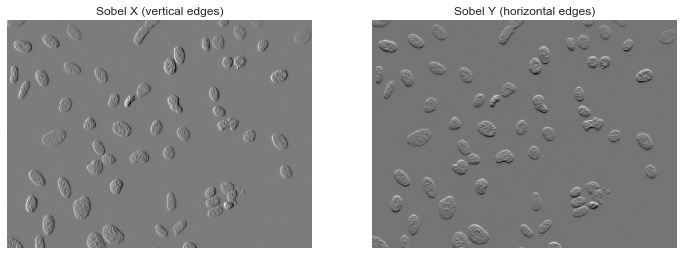

In [29]:
#cv2.Sobel arguments - the image, output depth, order of derivative of x, order of derivative of y, kernel/filter matrix size
sobelx = cv2.Sobel(grayimg,int(cv2.CV_64F),1,0,ksize=3) #ksize=3 means we'll be using the 3x3 Sobel filter
sobely = cv2.Sobel(grayimg,int(cv2.CV_64F),0,1,ksize=3) # dx=0 ,dy=1

#To plot the vertical and horizontal edge detectors side by side
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(sobelx,cmap='gray')
plt.title('Sobel X (vertical edges)')
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(sobely,cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Sobel Y (horizontal edges)')

Text(0.5, 1.0, 'Sobel Filter')

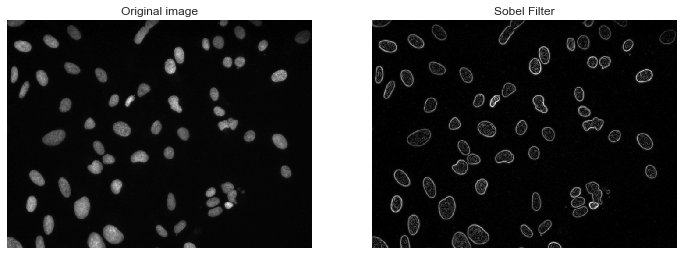

In [30]:
#Plotting the original image
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(grayimg,cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Original image')

#Now to combine the 2 sobel filters
sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
plt.subplot(1,2,2)
plt.imshow(sobel,cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Sobel Filter')

Aha! The Sobel filter has done better than Otsu/KMeans in identifying distinct objects in the image. The two nuclei in the top right corner, the two extremely small nuclei at the (530,410) mark (tentative) have been identified. However minor concerns remain as 2 of the 3 overlapping nuclei in the same region have been considered as 1, instead of all 3 before.



([], <a list of 0 Text yticklabel objects>)

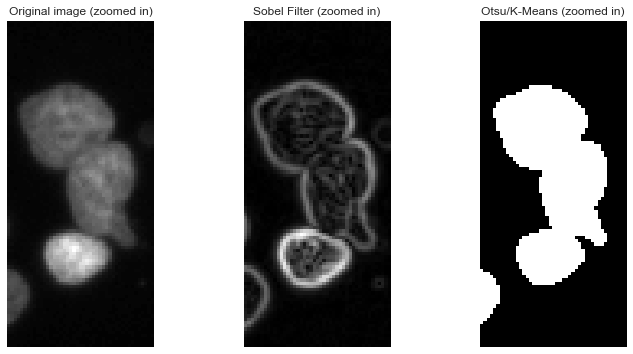

In [31]:
#To highlight the problem areas
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(grayimg[350:450,485:530],cmap='gray')
plt.title('Original image (zoomed in)')
plt.xticks([])
plt.yticks([])


plt.subplot(1,3,2)
plt.imshow(sobel[350:450,485:530],cmap='gray')
plt.title('Sobel Filter (zoomed in)')
plt.xticks([])
plt.yticks([])

plt.subplot(1,3,3)
plt.imshow(maskimg[350:450,485:530], cmap='gray')
plt.title('Otsu/K-Means (zoomed in)')
plt.xticks([])
plt.yticks([])

So there is definitely an improvement. However as pointed out here (https://www.kaggle.com/c/data-science-bowl-2018/discussion/47864), this problem is an instance segmentation problem. Distinguishing foreground objects from background is not the primary objective. If we fail to include a mask for a particular nucleus (like in the above mentioned example of the 2 overlapping nuclei), our score goes down

Now, let's try the Canny edge detector which is a smarter Sobel Filter. The Canny edge detector is a multistage algorithm:-

- The first stage removes the background noise in the image using a Gaussian filter so that the algorithm detects real edges
- The second stage finds an intensity gradient in the image using a Sobel filter (using a combination of sobel-x and sobel-y)
- The third stage unwanted pixels are removed so they will not be confused as edge. To do this, the entire image is analyzed, checking if each pixel is a local maximum in the direction of the gradient relative to its area. 
- Finally the last stage is the application of the Hysteresis Thresholding In this final stage the algorithm determines which edges are real edge and and those who are not at all. For this you must determine **two threshold values, the minVal the minimum threshold, and maxVal the maximum threshold**. Any edge with an intensity gradient greater than maxval is sure to be an edge, and those with a value less than minVal will be discarded, because they are nor real edge. For all other edge that may be found in the range between these two threshold values, are subjected to a further analysis, establishing whether they are real edges through their connectivity

Read more at http://www.meccanismocomplesso.org/en/opencv-python-canny-edge-detection/#RqetSzirOmJRYDup.99



([], <a list of 0 Text yticklabel objects>)

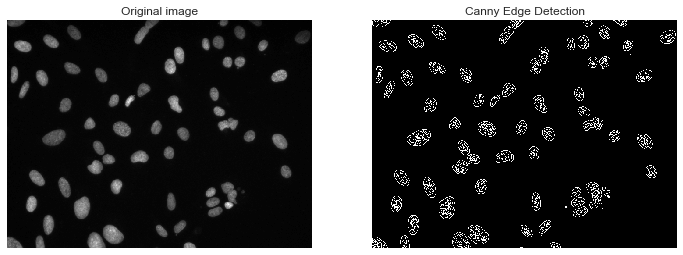

In [32]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(grayimg,cmap='gray')
plt.title('Original image')
plt.xticks([])
plt.yticks([])

#Let's see how the Canny Edge Detector does on the image
plt.subplot(1,2,2)
canny = cv2.Canny(grayimg,0,21)
plt.imshow(canny,cmap='gray')
plt.title('Canny Edge Detection')
plt.xticks([])
plt.yticks([])

So the Canny Edge Detector has found gradient within the nuclei as well which gives an impression that it is an overkill. However if we were to retrieve the external contours only and create masks based on these external contours, then we may create masks that capture the region of interest. One point to note is that the same problems that we faced with Sobel filter are visible here, however the Canny Edge Detector has returned a modified image matrix where we only have binary values (0 and 255)

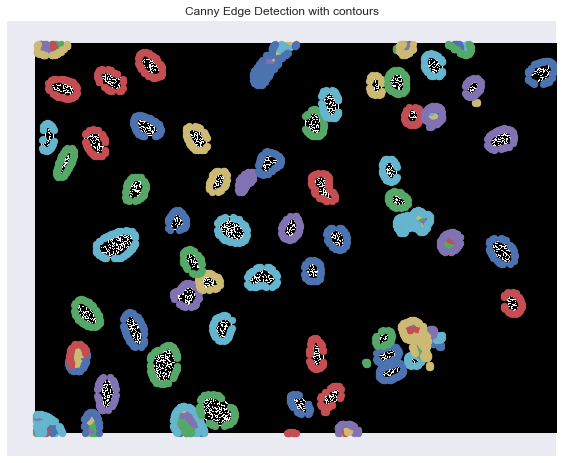

In [35]:
#Using contouring to create the masks
canny_cont=cv2.findContours(canny,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[1] #Using an approximation function to obtain the contour points and retreiving only the external contours

#To show the contour points
plt.figure(figsize=(14,8))
plt.imshow(canny,cmap='gray')
plt.title('Canny Edge Detection with contours')
plt.xticks([])
plt.yticks([])

for i in (range(len(canny_cont))):
    plt.scatter(canny_cont[i].flatten().reshape(len(canny_cont[i]),2)[:,0],
         canny_cont[i].flatten().reshape(len(canny_cont[i]),2)[:,1])



([], <a list of 0 Text yticklabel objects>)

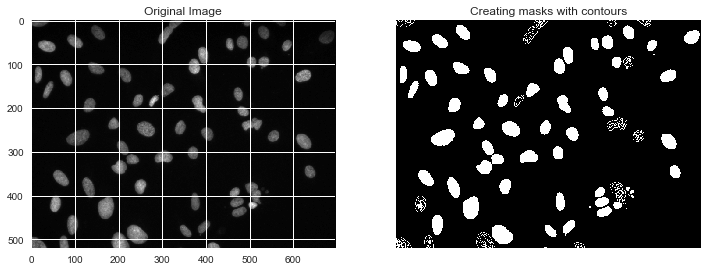

In [39]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(grayimg, cmap='gray')
plt.title('Original Image')

#Now to create masks with contours
background=np.zeros(grayimg.shape)
canny_mask=cv2.drawContours(background,canny_cont,-1,255,-1)

plt.subplot(1,2,2)
plt.imshow(canny_mask,cmap='gray')
plt.title('Creating masks with contours')
plt.xticks([])
plt.yticks([])

Now, the Canny Edge Detector has been able to find out most of the nuclei, however we aren't getting complete masks for each of the nuclei. This could be changed by using different values for the minval and maxval parameters (in the cv2.Canny() function) which also depends on the kind of image that we are dealing with (as we will see later). The output of the canny_mask matrix is in the form that allows us to use ndimage.labels, the function used for finding connected components. However it is absolutely important that we make complete masks for each nuclei so that we don't find more objects than there are in this image.

In [40]:
canny_mask_copy=canny_mask.copy()
canny_mask_clabels=ndimage.label(canny_mask_copy)[0]

In [41]:
for label_ind, label_mat in enumerate(ndimage.find_objects(canny_mask_clabels)):
    cell = canny_mask_clabels[label_mat]
    #Toheck if the label size is too small
    if np.product(cell.shape) < 100:
        canny_mask_clabels[np.where(canny_mask_clabels==label_ind+1)]=1
canny_mask_clabels=np.where(canny_mask_clabels>1,0,canny_mask_clabels)



([], <a list of 0 Text yticklabel objects>)

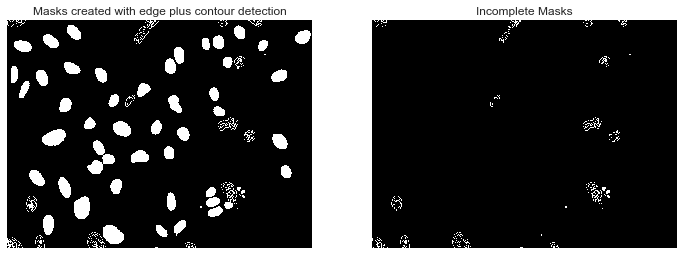

In [42]:
#To show the original mask
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(canny_mask,cmap='gray')
plt.title('Masks created with edge plus contour detection')
plt.xticks([])
plt.yticks([])

#To plot the problem areas
plt.subplot(1,2,2)
plt.imshow(canny_mask_clabels,cmap='gray')
plt.title('Incomplete Masks')
plt.xticks([])
plt.yticks([])

In [43]:
#For convolving 2D arrays
from scipy import signal

/Users/StevenTseng/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/Users/StevenTseng/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'Smoothened Canny Mask with Otsu threshold value')

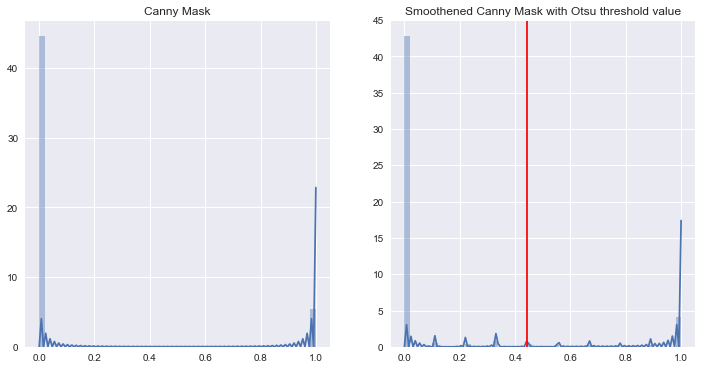

In [44]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.distplot(np.where(canny_mask==255,1,0).flatten())
plt.title('Canny Mask')

plt.subplot(1,2,2)
#To smooth the canny_mask by convolving with a matrix that has all values = 1/9
canny_mask_smooth=signal.convolve2d(np.where(canny_mask==255,1,0),np.full((3,3),1/9),'same')
sns.distplot(canny_mask_smooth.flatten())
canny_mask_smooth_thresh=threshold_otsu(canny_mask_smooth)
plt.axvline(x=canny_mask_smooth_thresh,color='r')
plt.title('Smoothened Canny Mask with Otsu threshold value')

The number of pixels with intensity values = 1 has reduced. Why has this happened? This is because of smoothing. We have convolved the canny mask with a local filter (a 3x3 matrix with all values = 1/9) and what this does is that it replaces the intensity values of the pixels by the average of the intensity values of the neighboring pixels. Now if a pixel has all neighbouring pixels with intensity values = 1, the intensity value of the pixel stays as 1 (as 1/9 x 9 =1). However the pixels at the edges of the objects and at the problem areas have reduced intensity values



([], <a list of 0 Text yticklabel objects>)

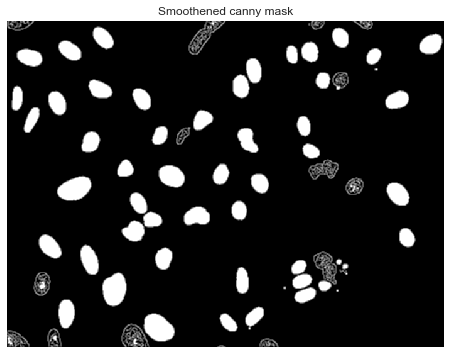

In [45]:
plt.figure(figsize=(12,6))
plt.imshow(canny_mask_smooth,cmap='gray')
plt.title('Smoothened canny mask')
plt.xticks([])
plt.yticks([])

Text(0.5, 1.0, 'After 1 convolution')

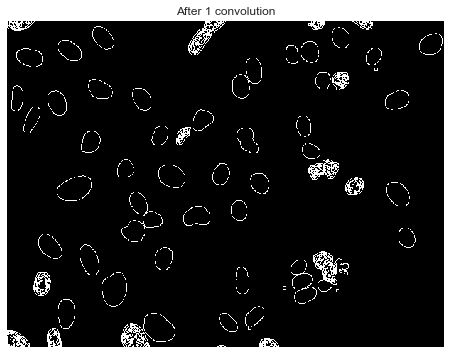

In [46]:
#Setting all values above otsu's threshold as 0 in the matrix and in this image matrix setting all values above 0 as 1 
plt.figure(figsize=(12,6))
canny_conv1=np.where(np.where(canny_mask_smooth>canny_mask_smooth_thresh,0,canny_mask_smooth)>0,1,0)
plt.imshow(canny_conv1,cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('After 1 convolution')


Text(0.5, 1.0, 'After 2 convolutions')

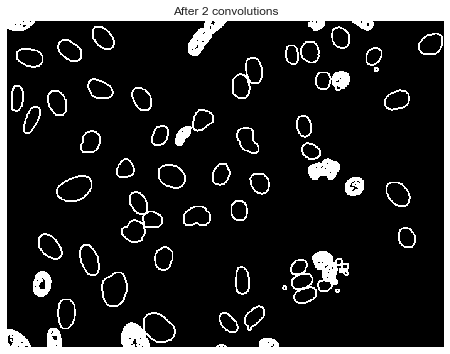

In [47]:
plt.figure(figsize=(12,6))
canny_mask_smooth2=signal.convolve2d(canny_conv1,np.full((3,3),1/9),'same')
canny_mask_smooth_thresh2=threshold_otsu(canny_mask_smooth2)
canny_conv2=np.where(canny_mask_smooth2>canny_mask_smooth_thresh2,1,0)
plt.imshow(canny_conv2,cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('After 2 convolutions')


([], <a list of 0 Text yticklabel objects>)

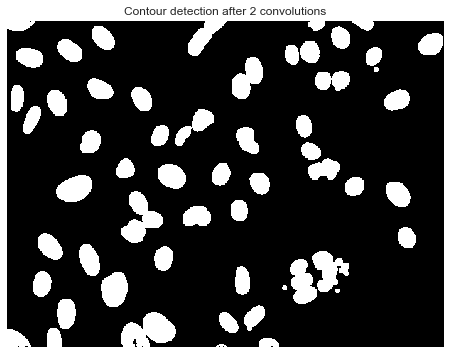

In [48]:
#Combing the 2 convolutions 
canny_cont=cv2.findContours(cv2.convertScaleAbs(canny_conv2),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[1]
background=np.zeros(grayimg.shape)
canny_mask=cv2.drawContours(background,canny_cont,-1,255,-1)

plt.figure(figsize=(12,6))
plt.imshow(canny_mask,cmap='gray')
plt.title('Contour detection after 2 convolutions')
plt.xticks([])
plt.yticks([])


So this looks good. Some of the earlier problems remain as some nuclei are still clustered together but the bottomline is that we have been able to identify all the nuclei in the original picture. Before we try any of this and end up overfitting to a well behaved image, it is important to see what values for MinVal and MaxVal parameters in the cv2.Canny() function work on other images.



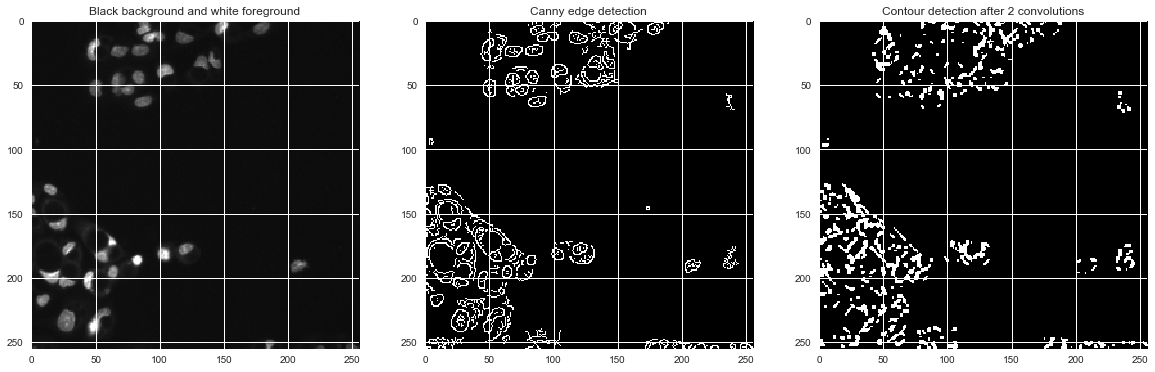

In [49]:
#Let's try the same parameters for canny edge on other types of images - starting with another black background and white foreground image

for i in range(len(training_sorted)):
    if training_sorted[i].parts[-1]=='feffce59a1a3eb0a6a05992bb7423c39c7d52865846da36d89e2a72c379e5398.png':
        bwimg=cv2.imread(str(training_sorted[i]))
        bwimg=cv2.cvtColor(bwimg,cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(20,8))
        plt.subplot(1,3,1)
        plt.imshow(bwimg)
        plt.title('Black background and white foreground')
        
        plt.subplot(1,3,2)
        bwimg=cv2.cvtColor(bwimg,cv2.COLOR_RGB2GRAY)
        bwimg_canny=cv2.Canny(bwimg,0,21)
        plt.imshow(bwimg_canny,cmap='gray')
        plt.title('Canny edge detection')
        
        plt.subplot(1,3,3)
        bwimg_cont=cv2.findContours(bwimg_canny,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[1]
        #Now to create masks with contours
        bwimg_bg=np.zeros(bwimg.shape)
        bwimg_mask=cv2.drawContours(bwimg_bg,bwimg_cont,-1,255,-1)
        
        #Convolving once
        bwimg_mask_smooth=signal.convolve2d(np.where(bwimg_mask==255,1,0),np.full((3,3),1/9),'same')
        bwimg_mask_smooth_thresh=threshold_otsu(bwimg_mask_smooth)
        bwimg_conv1=np.where(np.where(bwimg_mask_smooth>bwimg_mask_smooth_thresh,0,bwimg_mask_smooth)>0,1,0)
        
        #Convolving again
        bwimg_mask_smooth2=signal.convolve2d(bwimg_conv1,np.full((3,3),1/9),'same')
        bwimg_mask_smooth_thresh2=threshold_otsu(bwimg_mask_smooth2)
        bwimg_conv2=np.where(bwimg_mask_smooth2>bwimg_mask_smooth_thresh2,1,0)
        
        #Now to create masks with contours after 2 convolutions
        bwimg_cont=cv2.findContours(cv2.convertScaleAbs(bwimg_conv2),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[1]
        bwimg_bg=np.zeros(bwimg.shape)
        bwimg_mask=cv2.drawContours(bwimg_bg,bwimg_cont,-1,255,-1)

        plt.imshow(bwimg_mask,cmap='gray')
        plt.title('Contour detection after 2 convolutions')

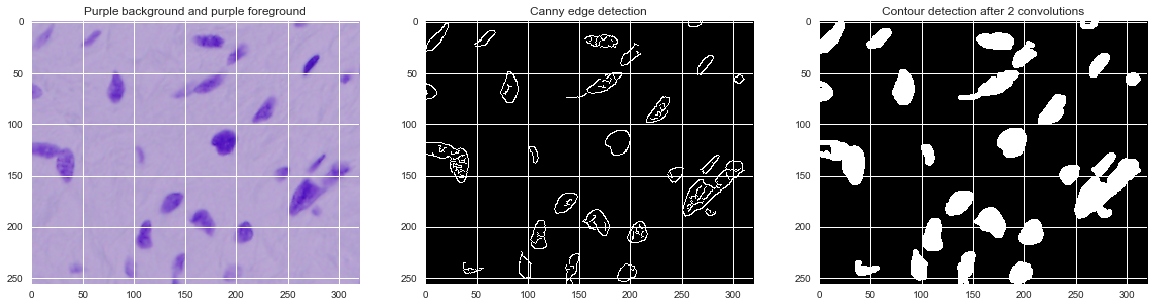

In [63]:

#Purple background and purple foreground
for i in range(len(training_sorted)):
    if training_sorted[i].parts[-1]=='0e21d7b3eea8cdbbed60d51d72f4f8c1974c5d76a8a3893a7d5835c85284132e.png':
        ppimg=cv2.imread(str(training_sorted[i]))
        ppimg=cv2.cvtColor(ppimg,cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(20,8))
        plt.subplot(1,3,1)
        plt.imshow(ppimg)
        plt.title('Purple background and purple foreground')
        
        plt.subplot(1,3,2)
        ppimg=cv2.cvtColor(ppimg,cv2.COLOR_RGB2GRAY)
        ppimg_canny=cv2.Canny(ppimg,20,100)
        plt.imshow(ppimg_canny,cmap='gray')
        plt.title('Canny edge detection')
        
        plt.subplot(1,3,3)
        ppimg_cont=cv2.findContours(ppimg_canny,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[1]
        #Now to create masks with contours
        ppimg_bg=np.zeros(ppimg.shape)
        ppimg_mask=cv2.drawContours(ppimg_bg,ppimg_cont,-1,255,-1)
        
        #Convolving once
        ppimg_mask_smooth=signal.convolve2d(np.where(ppimg_mask==255,1,0),np.full((3,3),1/9),'same')
        ppimg_mask_smooth_thresh=threshold_otsu(ppimg_mask_smooth)
        ppimg_conv1=np.where(np.where(ppimg_mask_smooth>ppimg_mask_smooth_thresh,0,ppimg_mask_smooth)>0,1,0)
        
        #Convolving again
        ppimg_mask_smooth2=signal.convolve2d(ppimg_conv1,np.full((3,3),1/9),'same')
        ppimg_mask_smooth_thresh2=threshold_otsu(ppimg_mask_smooth2)
        ppimg_conv2=np.where(ppimg_mask_smooth2>ppimg_mask_smooth_thresh2,1,0)
                                     
        #Now to create masks with contours after 2 convolutions
        ppimg_cont=cv2.findContours(cv2.convertScaleAbs(ppimg_conv2),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[1]
        ppimg_bg=np.zeros(ppimg.shape)
        ppimg_mask=cv2.drawContours(ppimg_bg,ppimg_cont,-1,255,-1)

        plt.imshow(ppimg_mask,cmap='gray')
        plt.title('Contour detection after 2 convolutions')


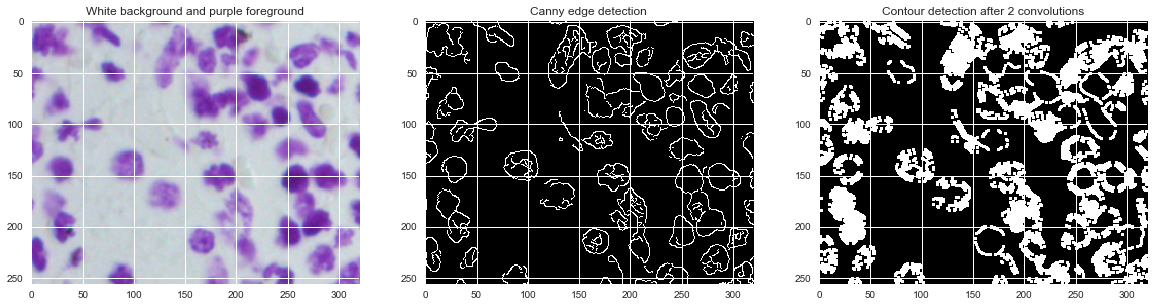

In [64]:
#White background and purple foreground
for i in range(len(training_sorted)):
    if training_sorted[i].parts[-1]=='0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed.png':
        wpimg=cv2.imread(str(training_sorted[i]))
        wpimg=cv2.cvtColor(wpimg,cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(20,8))
        plt.subplot(1,3,1)
        plt.imshow(wpimg)
        plt.title('White background and purple foreground')
        
        plt.subplot(1,3,2)
        wpimg=cv2.cvtColor(wpimg,cv2.COLOR_RGB2GRAY)
        wpimg_canny=cv2.Canny(wpimg,20,100)
        plt.imshow(wpimg_canny,cmap='gray')
        plt.title('Canny edge detection')
        
        plt.subplot(1,3,3)
        wpimg_cont=cv2.findContours(wpimg_canny,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[1]
        #Now to create masks with contours
        wpimg_bg=np.zeros(wpimg.shape)
        wpimg_mask=cv2.drawContours(wpimg_bg,wpimg_cont,-1,255,-1)
        
        #Convolving once
        wpimg_mask_smooth=signal.convolve2d(np.where(wpimg_mask==255,1,0),np.full((3,3),1/9),'same')
        wpimg_mask_smooth_thresh=threshold_otsu(wpimg_mask_smooth)
        wpimg_conv1=np.where(np.where(wpimg_mask_smooth>wpimg_mask_smooth_thresh,0,wpimg_mask_smooth)>0,1,0)
        
        #Convolving again
        wpimg_mask_smooth2=signal.convolve2d(wpimg_conv1,np.full((3,3),1/9),'same')
        wpimg_mask_smooth_thresh2=threshold_otsu(wpimg_mask_smooth2)
        wpimg_conv2=np.where(wpimg_mask_smooth2>wpimg_mask_smooth_thresh2,1,0)
        
        #Now to create masks with contours after 2 convolutions
        wpimg_cont=cv2.findContours(cv2.convertScaleAbs(wpimg_conv2),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[1]
        wpimg_bg=np.zeros(wpimg.shape)
        wpimg_mask=cv2.drawContours(wpimg_bg,wpimg_cont,-1,255,-1)

        plt.imshow(wpimg_mask,cmap='gray')
        plt.title('Contour detection after 2 convolutions')

### Pixel Classifier

Right, so it's time to bring Machine Learning into the perspective. In this section, we'll try to build a pixel classifier that classifies pixels as 0 or 255 depending on the grayscale values of the pixel and its neighbors.

In [65]:
train_path = '/Users/StevenTseng/Desktop/stage1_train/'
test_path = '/Users/StevenTseng/Desktop/stage1_test/'
train_ids = os.listdir(train_path)
def LabelMerge(imgpath):
    #to get all the png files
    png_files = [f for f in os.listdir(imgpath) if f.endswith('.png')]
    #to load the image as a grayscale
    img = cv2.imread(imgpath+'/'+png_files[0],0)
    for i in png_files[1:]:
        temp_img = cv2.imread(imgpath+'/'+i,0)
        img = img+temp_img
    return(img)

Text(0.5, 1.0, 'Combined Mask')

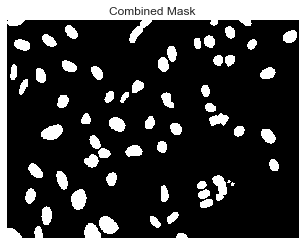

In [66]:
path = train_path+training_sorted[45].parts[-3]+'/masks/'
combined_mask=LabelMerge(path)
plt.imshow(combined_mask,cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Combined Mask')

We will use the bounding boxes of the nuclei that we find in our created mask to localize the nuclei in the original image (and use its grayscale values) and use the values of the pixels in the combined mask for that bounding box as labels.

By using bounding boxes, we are trying to localize regions of interest. It's fine if we have 2-3 nuclei clustered together to form one bounding box (the performance will improve if we are able to sperate them but it shouldn't come at the cost of not detecting a few bounding boxes i.e false negatives) or if we have more bounding boxes than nuclei in the image (false positives). The job of classifying a pixel as 255 or 0 is left to the pixel classifier and in that sense the classifier is only dependent on the grayscale values in the original image and the corresponding labels in the combined mask. We are essentially only looking at those regions that interest us and everything outside these regions is classified as a 0. By including the grayscale values of the neighboring pixels in the dataframe, we are giving the pixel classifier some context. The intuition is that if we find a bounding box in our created mask where there is no nucleus at all, our pixel classifier should set the values of the pixels in that box to 0. What we can't afford though, is to not look at a region where there is a nucleus, because if we do that, then the pixel classifier won't have anything to classify and with our current pipeline, the pixels in that region will be set to 0. The pixel classifier is only as good as the features you define.



Text(0.5, 1.0, 'Label from the combined mask')

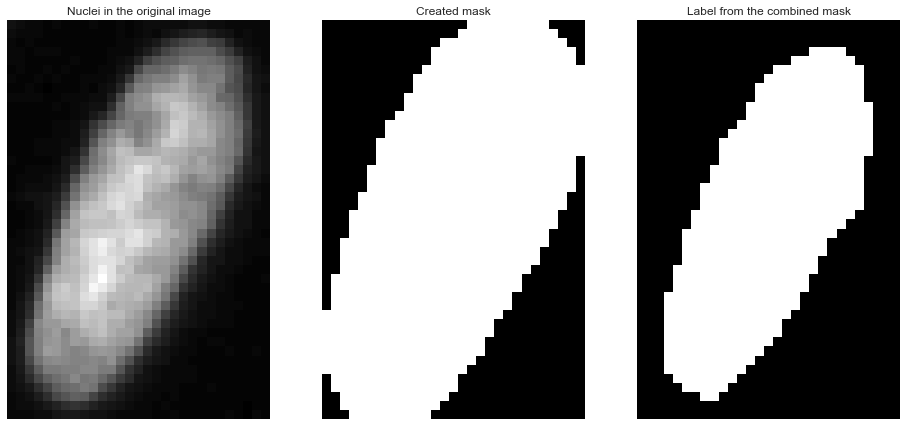

In [67]:
objects=ndimage.label(canny_mask)[0]
plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.imshow(grayimg[ndimage.find_objects(objects)[20]],cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Nuclei in the original image')

plt.subplot(1,3,2)
plt.imshow(canny_mask[ndimage.find_objects(objects)[20]],cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Created mask')

plt.subplot(1,3,3)
plt.imshow(combined_mask[ndimage.find_objects(objects)[20]],cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Label from the combined mask')

In [ ]:
#To get one dataframe for all the pixels within all the bounding boxes in an image
pixels_gs=pd.DataFrame()
columns=[]
for i in range(9):
    columns.append('pixel-'+str(i))
columns=columns+['label']
bounding=ndimage.find_objects(objects)
for bbox in bounding:
    for i in range(1,canny_mask[bbox].shape[0]-1):
        for j in range(1,canny_mask[bbox].shape[1]-1):
            pixel0=grayimg[bbox][i][j] #center pixel
            pixel1=grayimg[bbox][i-1][j-1] #top left pixel
            pixel2=grayimg[bbox][i-1][j] #pixel above the center pixel
            pixel3=grayimg[bbox][i-1][j+1] #top right pixel
            pixel4=grayimg[bbox][i][j-1] #pixel to the left of center pixel
            pixel5=grayimg[bbox][i][j+1] #pixel to the right of center pixel
            pixel6=grayimg[bbox][i+1][j-1] #bottom left pixel
            pixel7=grayimg[bbox][i+1][j] #pixel to the bottom of center pixel 
            pixel8=grayimg[bbox][i+1][j+1] #bottom right pixel
            label=combined_mask[i][j] #label of the center pixel
            neighbors = pd.Series({a:b for (a,b) in zip(columns,[pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,label])})
            pixels_gs = pixels_gs.append(neighbors, ignore_index=True)

In [ ]:
#To see the head of the dataframe
pixels_gs.head()